# ECMM447 - MINI PROJECT
## Text Summarization using NLP techniques
### By (710075868) 

# **Import the Libraries**

In [ ]:
from keras import backend as K 
import gensim
from numpy import *
import numpy as np
import pandas as pd 
from nltk.corpus import stopwords
import nltk
import re
from bs4 import BeautifulSoup
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences
from nltk.corpus import stopwords
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import warnings
pd.set_option("display.max_colwidth", 200)
warnings.filterwarnings("ignore")

In [ ]:
# To Upgrade NLTK to >3.5 for METEOR score
!pip install -U nltk 

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
print('The nltk version is {}.'.format(nltk.__version__)) # Verify version >3.5

The nltk version is 3.8.1.


# Read the dataset

In [ ]:
summary = pd.read_csv('news_summary.csv', encoding='iso-8859-1')


In [ ]:
raw = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

In [ ]:
print(summary.shape)
raw.shape


(4514, 6)


(98401, 2)

In [ ]:
pre_data1 =  raw.iloc[:,0:2].copy()

pre_data2 = summary.iloc[:,0:6].copy()
pre_data2['text'] = pre_data2['author'].str.cat(pre_data2['date'].str.cat(pre_data2['read_more'].str.cat(pre_data2['text'].str.cat(pre_data2['ctext'], sep = " "), sep =" "),sep= " "), sep = " ")

In [ ]:
pre_data = pd.DataFrame()
pre_data['text'] = pd.concat([pre_data1['text'], pre_data2['text']], ignore_index=True)
pre_data['summary'] = pd.concat([pre_data1['headlines'],pre_data2['headlines']],ignore_index = True)

In [ ]:
pre_data.head(2)

,text,summary
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...",upGrad learner switches to career in ML & Al with 90% salary hike
1,"Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...",Delhi techie wins free food from Swiggy for one year on CRED


In [ ]:
pre_data['text'][:5]

0    Saurav Kant, an alumnus of upGrad and IIIT-B's PG Program in Machine learning and Artificial Intelligence, was a Sr Systems Engineer at Infosys with almost 5 years of work experience. The program ...
1    Kunal Shah's credit card bill payment platform, CRED, gave users a chance to win free food from Swiggy for one year. Pranav Kaushik, a Delhi techie, bagged this reward after spending 2000 CRED coi...
2    New Zealand defeated India by 8 wickets in the fourth ODI at Hamilton on Thursday to win their first match of the five-match ODI series. India lost an international match under Rohit Sharma's capt...
3    With Aegon Life iTerm Insurance plan, customers can enjoy tax benefits on your premiums paid and save up to Ã¢ÂÂ¹46,800^ on taxes. The plan provides life cover up to the age of 100 years. Also, c...
4    Speaking about the sexual harassment allegations against Rajkumar Hirani, Sonam Kapoor said, "I've known Hirani for many years...What if it's not true, the [#MeToo] movement w

# **Perform Data Cleansing**

In [ ]:
type(pre_data)
pre_data.shape
print(pre_data.info())
print(pre_data["text"].isnull().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 102915 entries, 0 to 102914
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   text     102797 non-null  object
 1   summary  102915 non-null  object
dtypes: object(2)
memory usage: 1.6+ MB
None
118


## **Drop Duplicates and NA values**

In [ ]:
pre_data.drop_duplicates(subset=['text'],inplace=True)#dropping duplicates
pre_data.dropna(subset=['text'], inplace=True)

In [ ]:
print(pre_data["text"].isnull().sum())
pre_data["summary"].isnull().sum()

0


0

In [ ]:
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

# Preprocessing

In [ ]:
contraction_mapping = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

We will perform the below preprocessing tasks for our data:

1.Convert everything to lowercase

2.Remove HTML tags

3.Contraction mapping

4.Remove (‘s)

5.Remove any text inside the parenthesis ( )

6.Eliminate punctuations and special characters

7.Remove stopwords

8.Remove short words

Let’s define the function:

In [ ]:
stop_words = set(stopwords.words('english')) 

def text_cleaner(text,num):
    newString = text.lower()
    newString = BeautifulSoup(newString, "lxml").text
    newString = re.sub(r'\([^)]*\)', '', newString)
    newString = re.sub('"','', newString)
    newString = ' '.join([contraction_mapping[t] if t in contraction_mapping else t for t in newString.split(" ")])    
    newString = re.sub(r"'s\b","",newString)
    newString = re.sub("[^a-zA-Z]", " ", newString) 
    newString = re.sub('[m]{2,}', 'mm', newString)
    if(num==0):
        tokens = [w for w in newString.split() if not w in stop_words]
    else:
        tokens=newString.split()
    long_words=[]
    for i in tokens:
        if len(i)>1:                                                 #removing short word
            long_words.append(i)   
    return (" ".join(long_words)).strip()

In [ ]:
#call the function
cleaned_text = []
for t in pre_data['text']:
    cleaned_text.append(text_cleaner(t,0)) 

In [ ]:
cleaned_text[:5]  

['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers',
 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit',
 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history',
 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical il

In [ ]:
#call the function
cleaned_summary = []
for t in pre_data['summary']:
    cleaned_summary.append(text_cleaner(t,1))

In [ ]:
cleaned_summary[:5]

['upgrad learner switches to career in ml al with salary hike',
 'delhi techie wins free food from swiggy for one year on cred',
 'new zealand end rohit sharma led india match winning streak',
 'aegon life iterm insurance plan helps customers save tax',
 'have known hirani for yrs what if metoo claims are not true sonam']

In [ ]:
pre_data['cleaned_text']=cleaned_text
pre_data['cleaned_summary']=cleaned_summary

In [ ]:
# cleaned_text

In [ ]:
type(cleaned_text)

list

# **Drop empty rows**

In [ ]:
pre_data.replace('', np.nan, inplace=True)
pre_data.dropna(axis=0,inplace=True)

In [ ]:
pre_data.shape

(102756, 4)

# **Understanding the distribution of the sequences**

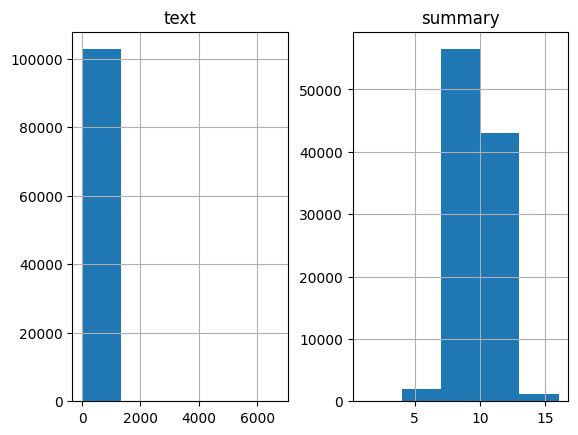

In [ ]:
import matplotlib.pyplot as plt

text_word_count = []
summary_word_count = []

# populate the lists with sentence lengths
for i in pre_data['cleaned_text']:
      text_word_count.append(len(i.split()))

for i in pre_data['cleaned_summary']:
      summary_word_count.append(len(i.split()))

length_df = pd.DataFrame({'text':text_word_count, 'summary':summary_word_count})

length_df.hist(bins = 5)
plt.show()

Interesting. We can fix the maximum length of the summary to 11 since that seems to be the majority summary length
Let us understand the proportion of the length of summaries below 11

In [ ]:
cnt=0
for i in pre_data['cleaned_summary']:
    if(len(i.split())<=11):
        cnt=cnt+1
print(cnt/len(pre_data['cleaned_summary']))

0.9459690918291875


We observe that 94% of the summaries have length below 11. So, we can fix maximum length of summary to 11.

Let us fix the maximum length of text to 50

In [ ]:
cnt=0
for i in pre_data['cleaned_text']:
    if(len(i.split())<=50):
        cnt=cnt+1
print(cnt/len(pre_data['cleaned_text']))

0.9570925298766009


In [ ]:
max_text_len=50
max_summary_len=11

Select the Summaries and Text whose length falls below or equal to max_text_len and max_summary_len

In [ ]:
pre_data.shape

(102756, 4)

In [ ]:
cleaned_text =np.array(pre_data['cleaned_text'])
cleaned_summary=np.array(pre_data['cleaned_summary'])

short_text=[]
short_summary=[]

for i in range(len(cleaned_text)):
    if(len(cleaned_summary[i].split())<=max_summary_len and len(cleaned_text[i].split())<=max_text_len):
        short_text.append(cleaned_text[i])
        short_summary.append(cleaned_summary[i])
        
post_pre_data=pd.DataFrame({'text':short_text,'summary':short_summary})

In [ ]:
post_pre_data.shape

(92936, 2)

Remember to add the START and END special tokens at the beginning and end of the summary. Here, I have chosen sostok and eostok as START and END tokens

Note: Be sure that the chosen special tokens never appear in the summary

In [ ]:
#Add sostok and eostok at 
post_pre_data['summary'] = post_pre_data['summary'].apply(lambda x : 'sostok '+ x + ' eostok')


In [ ]:
post_pre_data.head(2)

,text,summary
0,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...,upgrad learner switches to career in ml al with salary hike
1,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,new zealand end rohit sharma led india match winning streak


We are getting closer to the model building part. Before that, we need to split our dataset into a training and validation set. We’ll use 90% of the dataset as the training data and evaluate the performance on the remaining 10% (holdout set):

**SEQ2SEQ MODEL BUILDING **

Split the data to TRAIN and VALIDATION sets

In [ ]:
post_pre_data.shape

(92936, 2)

In [ ]:
from sklearn.model_selection import train_test_split
x_tr,x_val,y_tr,y_val=train_test_split(np.array(post_pre_data['text']),np.array(post_pre_data['summary']),test_size=0.1,random_state=0,shuffle=True)

In [ ]:
print(x_tr.shape)   #text 
print(x_val.shape)  #summaries
print(y_tr.shape)   #text
y_val.shape        #summaries

(83642,)
(9294,)
(83642,)


(9294,)

# **Preparing the Tokenizer**

A tokenizer builds the vocabulary and converts a word sequence to an integer sequence. Go ahead and build tokenizers for text and summary:

## **Text Tokenizer**

In [ ]:
from keras.preprocessing.text import Tokenizer 
from keras.utils import pad_sequences

#prepare a tokenizer for reviews on training data
x_tknizer = Tokenizer() 
x_tknizer.fit_on_texts(list(x_tr))

**RARE WORD ANALYSIS FOR X i.e 'text'**
* total_count ---> the size of vocabulary (which means every unique words in the text)

* count ---->the no. of rare words whose count falls below threshold

* (total_count - count) gives me the top most common words

In [ ]:
thresh=4

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in x_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 57.49926826208761
Total Coverage of rare words: 2.120991804400259


Let us define the tokenizer with top most common words for text.

In [ ]:
#prepare a tokenizer for "text" on training data
x_tknizer = Tokenizer(num_words=total_count-count) 
x_tknizer.fit_on_texts(list(x_tr))

#convert text sequences into integer sequences (i.e one-hot encodeing all the words)
x_tr_seq    =   x_tknizer.texts_to_sequences(x_tr) 
x_val_seq   =   x_tknizer.texts_to_sequences(x_val)

#padding zero upto maximum length
x_tr    =   pad_sequences(x_tr_seq,  maxlen=max_text_len, padding='post')
x_val   =   pad_sequences(x_val_seq, maxlen=max_text_len, padding='post')

#size of vocabulary ( +1 for padding token)
x_voc   =  x_tknizer.num_words + 1

print("Size of vocabulary in X = {}".format(x_voc))

Size of vocabulary in X = 30494


# **Summary Tokenizer**

In [ ]:
#prepare a tokenizer for reviews on training data
y_tknizer = Tokenizer()   
y_tknizer.fit_on_texts(list(y_tr))

**RARE WORD ANALYSIS FOR Y i.e 'summary'**
* total_count gives the size of vocabulary (which means every unique words in the text)

* count gives me the no. of rare words whose count falls below threshold

* (total_count - count) gives me the top most common words

In [ ]:
thresh=6

count=0
total_count=0
frequency=0
total_frequency=0

for key,value in y_tknizer.word_counts.items():
    total_count=total_count+1
    total_frequency=total_frequency+value
    if(value<thresh):
        count=count+1
        frequency=frequency+value
    
print("% of rare words in vocabulary:",(count/total_count)*100)
print("Total Coverage of rare words:",(frequency/total_frequency)*100)

% of rare words in vocabulary: 65.08768523911215
Total Coverage of rare words: 4.137533020520547


Let us define the tokenizer with top most common words for summary.

In [ ]:
#prepare a tokenizer for "summary" on training data
y_tknizer = Tokenizer(num_words=total_count-count) 
y_tknizer.fit_on_texts(list(y_tr))

#convert text sequences into integer sequences (i.e one hot encode the text in Y)
y_tr_seq    =   y_tknizer.texts_to_sequences(y_tr) 
y_val_seq   =   y_tknizer.texts_to_sequences(y_val) 

#padding zero upto maximum length
y_tr    =   pad_sequences(y_tr_seq, maxlen=max_summary_len, padding='post')
y_val   =   pad_sequences(y_val_seq, maxlen=max_summary_len, padding='post')

#size of vocabulary
y_voc  =   y_tknizer.num_words +1
print("Size of vocabulary in Y = {}".format(y_voc))

Size of vocabulary in Y = 10791


Let us check whether word count of start token is equal to length of the training data

In [ ]:
y_tknizer.word_counts['sostok'],len(y_tr)   

(83642, 83642)

### **We will now delete "Summary" i.e Y (both train and val) which has only _START_ sostok and _END_ eostok --> we did this earlier**

In [ ]:
ind=[]
for i in range(len(y_tr)):
    count=0
    for j in y_tr[i]:
        if j!=0:
            count=count+1
    if(count==2):          #if the counter cnt is equal to 2, it means that the summary contains only START and END tokens like this (y_tr = ["START END"]). In this case, we append the index i to the ind list.
        ind.append(i)

y_tr=np.delete(y_tr,ind, axis=0)   #Finally, we use np.delete to delete the rows with indices in the ind list from both y_tr and x_tr.
x_tr=np.delete(x_tr,ind, axis=0)

In [ ]:
ind=[]
for i in range(len(y_val)):
    count=0
    for j in y_val[i]:
        if j!=0:
            count=count+1
    if(count==2):
        ind.append(i)

y_val=np.delete(y_val,ind, axis=0)
x_val=np.delete(x_val,ind, axis=0)

In [ ]:
print(x_tr.shape)
print(y_tr.shape)

(83642, 50)
(83642, 11)


In [ ]:
print(y_val.shape)    #summaries
print(x_val.shape)    #text
x_val

(9294, 11)
(9294, 50)


array([[   5,   33, 4535, ...,    0,    0,    0],
       [   5,  113,  735, ...,    0,    0,    0],
       [   2, 1911,  341, ...,    0,    0,    0],
       ...,
       [ 579,    3,   13, ...,    0,    0,    0],
       [ 391,  218,  671, ...,    0,    0,    0],
       [3381, 2839, 3404, ...,    0,    0,    0]])

# Model -1 (3 Unidirectional Stacked LSTM Encoder and 1 unidirectional LSTM Decoder)

We are finally at the model building part. But before we do that, we need to familiarize ourselves with a few terms which are required prior to building the model.

**Return Sequences = True**: When the return sequences parameter is set to True, LSTM produces the hidden state and cell state for every timestep

**Return State = True**: When return state = True, LSTM produces the hidden state and cell state of the last timestep only

**Initial State:** This is used to initialize the internal states of the LSTM for the first timestep

**Stacked LSTM**: Stacked LSTM has multiple layers of LSTM stacked on top of each other. This leads to a better representation of the sequence. **I will do experiment with the multiple layers of the LSTM stacked on top of each other (it’s a great way to learn this)**

Here, we are building a 3 stacked LSTM for the encoder:


In [ ]:
K.clear_session()

latent_dim = 300
embedding_dim=200

##-------------------------------------------------------- ENCODER (embedding + lstm)------------------------- ------------------------##
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
enc_emb =  Embedding(x_voc, embedding_dim,trainable=True)(encoder_inputs)

#encoder lstm 1
encoder_lstm1 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

#encoder lstm 2
encoder_lstm2 = LSTM(latent_dim,return_sequences=True,return_state=True,dropout=0.4,recurrent_dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

#encoder lstm 3
encoder_lstm3=LSTM(latent_dim, return_state=True, return_sequences=True,dropout=0.4,recurrent_dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)


##---------------------------------------------------------- DECODER (embedding + lstm + dense)--------------------------- ----------------##
# Set up the decoder, using `encoder_states` as initial state.
decoder_inputs = Input(shape=(None,))

#embedding layer
dec_emb_layer = Embedding(y_voc, embedding_dim,trainable=True)
dec_emb = dec_emb_layer(decoder_inputs)

decoder_lstm = LSTM(latent_dim, return_sequences=True, return_state=True,dropout=0.4,recurrent_dropout=0.2)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(dec_emb,initial_state=[state_h, state_c])

#dense layer - softmax
decoder_dense =  TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model 
model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 200)      6098800     ['input_1[0][0]']                
                                                                                                  
 lstm (LSTM)                    [(None, 50, 300),    601200      ['embedding[0][0]']              
                                 (None, 300),                                                     
                                 (None, 300)]                                                     
                                                                                              

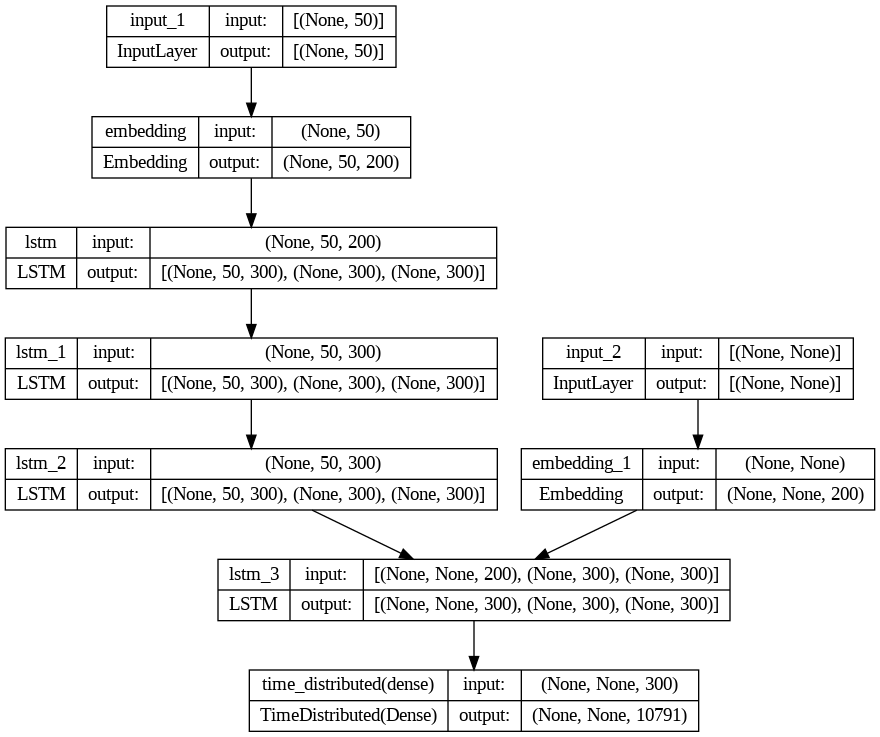

In [ ]:
from tensorflow.keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)


I am using sparse categorical cross-entropy as the loss function since it converts the integer sequence to a one-hot vector on the fly. This overcomes any memory issues.

In [ ]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

early stopping:-  It is used to stop training the neural network at the right time by monitoring a user-specified metric. Here, I am monitoring the validation loss (val_loss). Our model will stop training once the validation loss increases:

In [ ]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)


**Start fitting the model with the data**


training the model on a batch size of 128 and validate it on the holdout set (which is 10% of our dataset):

In [ ]:
history=model.fit([x_tr,y_tr[:,:-1]], 
                  y_tr.reshape(y_tr.shape[0],y_tr.shape[1], 1)[:,1:] ,
                  epochs=10,callbacks=[es],batch_size=128, 
                  validation_data=([x_val,y_val[:,:-1]], 
                                   y_val.reshape(y_val.shape[0],y_val.shape[1], 1)[:,1:]))

Epoch 1/10
654/654 [==============================] - 6215s 10s/step - loss: 6.3255 - val_loss: 6.0410
Epoch 2/10
654/654 [==============================] - 6760s 10s/step - loss: 5.9401 - val_loss: 5.7240
Epoch 3/10
654/654 [==============================] - 5008s 8s/step - loss: 5.5859 - val_loss: 5.3987
Epoch 4/10
654/654 [==============================] - 5993s 9s/step - loss: 5.2670 - val_loss: 5.1524
Epoch 5/10
654/654 [==============================] - 7686s 12s/step - loss: 5.0394 - val_loss: 4.9689
Epoch 6/10
654/654 [==============================] - 5914s 9s/step - loss: 4.8617 - val_loss: 4.8565
Epoch 7/10
654/654 [==============================] - 6028s 9s/step - loss: 4.7162 - val_loss: 4.7387
Epoch 8/10
654/654 [==============================] - 37474s 57s/step - loss: 4.5885 - val_loss: 4.6674
Epoch 9/10
654/654 [==============================] - 7076s 11s/step - loss: 4.4782 - val_loss: 4.5881
Epoch 10/10
654/654 [==============================] - 6033s 9s/step - loss:

In [ ]:
#save weights
model.save_weights('model/fitted_model')


Save the trained model

In [ ]:
# Save the model
model.save('my_model.h5')

Load the saved model

In [ ]:
from tensorflow.keras.models import load_model

# Load the saved model
saved_model = load_model('my_model.h5')


**Plot model learning curve**

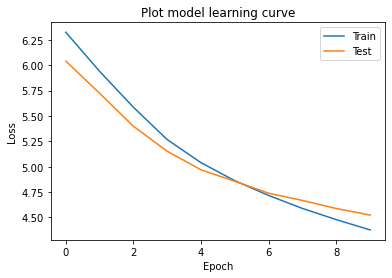

In [ ]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Plot model learning curve')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.show()




Next, let’s build the dictionary to convert the index to word for target and source vocabulary:

In [ ]:
reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

In [ ]:
# Encoding our input seq for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim))

dec_emb2= dec_emb_layer(decoder_inputs) 

# initial states from the previous time step
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# softmax for probability
decoder_outputs2 = decoder_dense(decoder_outputs2) 

decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

In [ ]:
def sequence_to_summary(input_seq):
    newString=''
    for i in input_seq:
        if((i!=0 and i!=target_word_index['sostok']) and i!=target_word_index['eostok']):
            newString=newString+reverse_target_word_index[i]+' '
    return newString

def sequence_to_text(input_seq):
    newString=''
    for i in input_seq:
        if(i!=0):
            newString=newString+reverse_source_word_index[i]+' '
    return newString

# Predict and print summaries from model - 1

In [ ]:
for i in range(0,10):
    print("text:",sequence_to_text(x_tr[i]))
    print("Original summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

text: us president donald trump threatened cut us financial aid countries vote favour resolution rejecting us recognition jerusalem israel capital united nations general assembly meeting thursday vote called protest recent us veto similar measure un security council meeting nnn 
Original summary: threatens to cut aid to nations over un jerusalem vote 
1/1 [==============================] - 0s 31ms/step
Predicted summary:  us prez trump calls us for jerusalem


text: year old indian american doctor found dead passenger seat car us state michigan earlier week suspect anything think hate crime said father victim deceased identified ramesh kumar graduate medical college kerala 
Original summary: indian american doctor found dead in car in us 
1/1 [==============================] - 0s 27ms/step
Predicted summary:  us man dies after being dead in us


text: elon musk led electric carmaking company tesla wednesday sued former employee martin tripp alleged stealing gigabytes confidential data 

In [ ]:
print(x_tr.shape)
print(y_tr.shape)

(83642, 50)
(83642, 11)


# Calculating scores

# Function to calculate ROUGE-1, ROUGE-2 and ROUGE-L 

In [ ]:
!pip install rouge

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge import Rouge

def calculate_rouge_scores(Original_summary, Predicted_summary):
    rouge = Rouge()
    scores = rouge.get_scores(Original_summary, Predicted_summary, avg=True)
    return scores

# Model 1 ROUGE scores

In [ ]:
Original_summary =  "threatens to cut aid to nations over un jerusalem vote"
Predicted_summary = "us prez trump calls us for jerusalem"

scores1 = calculate_rouge_scores(Original_summary, Predicted_summary)
scores1

{'rouge-1': {'r': 0.16666666666666666,
  'p': 0.1111111111111111,
  'f': 0.1333333285333335},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.16666666666666666,
  'p': 0.1111111111111111,
  'f': 0.1333333285333335}}

# Model -2 (1 Bidirectional LSTM Encoder and 1 unidirectional LSTM Decoder)

In [ ]:
K.clear_session()

latent_dim = 300
embedding_dim=200

##------------ ENCODER (embedding + lstm) ------------------------##
# Encoder
encoder_inputs = Input(shape=(max_text_len,))

#embedding layer
encoder_embedding = Embedding(x_voc, embedding_dim, trainable=True)(encoder_inputs)

encoder_lstm = Bidirectional(LSTM(latent_dim, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4))
encoder_outputs, forward_h, forward_c, backward_h, backward_c = encoder_lstm(encoder_embedding)
state_h = Concatenate()([forward_h, backward_h])
state_c = Concatenate()([forward_c, backward_c])

##------------ DECODER (embedding + lstm + dense) ----------------##
# Decoder
decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_embedding = Embedding(y_voc, embedding_dim, trainable=True)(decoder_inputs)

decoder_lstm = LSTM(latent_dim*2, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=[state_h, state_c])

decoder_dense = TimeDistributed(Dense(y_voc, activation='softmax'))
decoder_outputs = decoder_dense(decoder_outputs)

# Define the model
model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 50)]         0           []                               
                                                                                                  
 embedding (Embedding)          (None, 50, 200)      6098800     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, None)]       0           []                               
                                                                                                  
 bidirectional (Bidirectional)  [(None, 50, 600),    1202400     ['embedding[0][0]']              
                                 (None, 300),                                                 

In [ ]:
model2.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

es2 = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [ ]:
history2 = model2.fit([x_tr, y_tr[:,:-1]],
                    y_tr.reshape(y_tr.shape[0], y_tr.shape[1], 1)[:,1:],
                    epochs=10,
                    callbacks=[es2],
                    batch_size=128,
                    validation_data=([x_val, y_val[:,:-1]],
                                     y_val.reshape(y_val.shape[0], y_val.shape[1], 1)[:,1:]))

Epoch 1/10
654/654 [==============================] - 22178s 34s/step - loss: 6.2507 - val_loss: 5.7748
Epoch 2/10
654/654 [==============================] - 21571s 33s/step - loss: 5.5320 - val_loss: 5.2713
Epoch 3/10
654/654 [==============================] - 29657s 45s/step - loss: 5.0845 - val_loss: 4.9378
Epoch 4/10
654/654 [==============================] - 21821s 33s/step - loss: 4.7696 - val_loss: 4.7442
Epoch 5/10
654/654 [==============================] - 19402s 30s/step - loss: 4.5288 - val_loss: 4.5830
Epoch 6/10
654/654 [==============================] - 25278s 39s/step - loss: 4.3338 - val_loss: 4.4578
Epoch 7/10
654/654 [==============================] - 27608s 42s/step - loss: 4.1707 - val_loss: 4.3747
Epoch 8/10
654/654 [==============================] - 56944s 87s/step - loss: 4.0282 - val_loss: 4.3071
Epoch 9/10
654/654 [==============================] - 28366s 43s/step - loss: 3.9040 - val_loss: 4.2527
Epoch 10/10
654/654 [==============================] - 60941s 93

In [ ]:
reverse_target_word_index=y_tknizer.index_word
reverse_source_word_index=x_tknizer.index_word
target_word_index=y_tknizer.word_index

In [ ]:
# Encoder model for feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

# Decoder model for inference
decoder_state_input_h = Input(shape=(latent_dim*2,))
decoder_state_input_c = Input(shape=(latent_dim*2,))
decoder_hidden_state_input = Input(shape=(max_text_len,latent_dim*2))

# Embedding layer for decoder
dec_emb2= dec_emb_layer(decoder_inputs)

# LSTM layer for decoder
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

# Dense layer for output prediction
decoder_outputs2 = decoder_dense(decoder_outputs2) 

# Decoder model for inference
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

In [ ]:
def decode_sequence2(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    target_seq = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    target_seq[0, 0] = target_word_index['sostok']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition:
      
        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_target_word_index[sampled_token_index]
        
        if(sampled_token!='eostok'):
            decoded_sentence += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'eostok'  or len(decoded_sentence.split()) >= (max_summary_len-1)):
            stop_condition = True

        # Update the target sequence (of length 1).
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return decoded_sentence

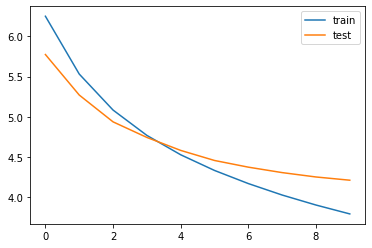

In [ ]:
from matplotlib import pyplot

pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


# **Predicted summary**

In [ ]:
for i in range(0,10):
    print("text:",sequence_to_text(x_tr[i]))
    print("Original summary:",(sequence_to_summary(y_tr[i])).replace('start', '').replace('end', ''))
    print("Predicted summary:",(decode_sequence2(x_tr[i].reshape(1,max_text_len))).replace('start', '').replace('end', ''))
    print("\n")

text: us president donald trump threatened cut us financial aid countries vote favour resolution rejecting us recognition jerusalem israel capital united nations general assembly meeting thursday vote called protest recent us veto similar measure un security council meeting nnn 
Original summary: threatens to cut aid to nations over un jerusalem vote 
1/1 [==============================] - 0s 48ms/step
Predicted summary:  us us us to to of in in trump


text: year old indian american doctor found dead passenger seat car us state michigan earlier week suspect anything think hate crime said father victim deceased identified ramesh kumar graduate medical college kerala 
Original summary: indian american doctor found dead in car in us 
1/1 [==============================] - 0s 41ms/step
Predicted summary:  found found found found of found for in dead


text: elon musk led electric carmaking company tesla wednesday sued former employee martin tripp alleged stealing gigabytes confidential da

# Model 2 ROUGE scores

In [ ]:

Original_summary =  "threatens to cut aid to nations over un jerusalem vote"
Predicted_summary = "us us us to to of in in trump"

scores2 = calculate_rouge_scores(Original_summary, Predicted_summary)
scores2

{'rouge-1': {'r': 0.2, 'p': 0.1111111111111111, 'f': 0.14285713826530627},
 'rouge-2': {'r': 0.0, 'p': 0.0, 'f': 0.0},
 'rouge-l': {'r': 0.2, 'p': 0.1111111111111111, 'f': 0.14285713826530627}}

# **Model 3 - T5**

In [ ]:
!pip install simplet5

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.5/3.5 MB 73.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 527.7/527.7 kB 39.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 952.4/952.4 kB 65.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 519.2/519.2 kB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 25.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 880.6/880.6 kB 50.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 91.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 69.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.5/114.5 kB 14.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━

In [ ]:
print(post_pre_data.shape)
post_pre_data.head()

(92936, 2)


,text,summary
0,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...,upgrad learner switches to career in ml al with salary hike
1,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,new zealand end rohit sharma led india match winning streak
2,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,aegon life iterm insurance plan helps customers save tax
3,pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads...,rahat fateh ali khan denies getting notice for smuggling currency
4,weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fir...,govt directs alok verma to join work day before his retirement


# T5 Data Prep with Training Data Column Names - source_text & target_text

In [ ]:
# simpleT5 expects dataframe to have 2 columns: "source_text" and "target_text"
df = post_pre_data.rename(columns={"summary":"target_text", "text":"source_text"})
df = df[['source_text', 'target_text']]
df.head()

,source_text,target_text
0,saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition ...,upgrad learner switches to career in ml al with salary hike
1,new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march ...,new zealand end rohit sharma led india match winning streak
2,aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability accidental deat...,aegon life iterm insurance plan helps customers save tax
3,pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publicised reads...,rahat fateh ali khan denies getting notice for smuggling currency
4,weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately join dg fir...,govt directs alok verma to join work day before his retirement


T5 Data Prep with Summarization Tax Prefix

In [ ]:
# T5 model expects a task related prefix: since it is a summarization task, we will add a prefix "summarize: "
df['source_text'] = "summarize: " + df['source_text']
df.head()

,source_text,target_text
0,summarize: saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped ...,upgrad learner switches to career in ml al with salary hike
1,summarize: new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating ...,new zealand end rohit sharma led india match winning streak
2,summarize: aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insure critical illnesses disability acci...,aegon life iterm insurance plan helps customers save tax
3,summarize: pakistani singer rahat fateh ali khan denied receiving notice enforcement directorate allegedly smuggling foreign currency india would better authorities would served notice first publi...,rahat fateh ali khan denies getting notice for smuggling currency
4,summarize: weeks ex cbi director alok verma told department personnel training consider retired home ministry asked join work last day fixed tenure director thursday ministry directed immediately ...,govt directs alok verma to join work day before his retirement


In [ ]:
from sklearn.model_selection import train_test_split

# Assuming 'df' is your pandas DataFrame
train_df, test_df = train_test_split(df, test_size=0.1)

# Check the shapes of the two DataFrames
print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)


Training data shape: (83642, 2)
Testing data shape: (9294, 2)


In [ ]:
print(train_df.shape)
print(test_df.shape)

(83642, 2)
(9294, 2)


# Using SimpleT5 for Model Training - Instantiate, Download Pre-trained Model

In [ ]:
from simplet5 import SimpleT5

model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-base")

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Downloading:   0%|          | 0.00/773k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.32M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/850M [00:00<?, ?B/s]

# Model - T5 Training

In [ ]:
# --> Finetuning T5 model with simpleT5
from simplet5 import SimpleT5

model = SimpleT5()
model.from_pretrained(model_type="t5", model_name="t5-base")
model.train(train_df=train_df,
            eval_df=test_df, 
            source_max_token_len=50, 
            target_max_token_len=11, 
            batch_size=8, max_epochs=3, use_gpu=True)

INFO:pytorch_lightning.utilities.distributed:GPU available: True, used: True
INFO:pytorch_lightning.utilities.distributed:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.distributed:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.accelerators.gpu:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

INFO:pytorch_lightning.utilities.seed:Global seed set to 42


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

# Output Folder Content

In [ ]:
! ( cd outputs; ls )

simplet5-epoch-0-train-loss-1.9106-val-loss-1.56
simplet5-epoch-1-train-loss-1.4548-val-loss-1.5067
simplet5-epoch-2-train-loss-1.2258-val-loss-1.5012


# Model Inference

In [ ]:
# let's load the trained model from the local output folder for inferencing:
model.load_model("t5","outputs/simplet5-epoch-2-train-loss-1.2258-val-loss-1.5012", use_gpu=True)

# **Predicted Summary  - showing Impressive Results**

In [ ]:
text_to_summarize="""us president donald trump threatened cut us financial aid countries vote favour resolution 
rejecting us recognition jerusalem israel capital united nations general assembly meeting thursday vote called protest recent us veto similar measure un security council meeting nnn """

model.predict(text_to_summarize)

['trump threatens to cut us aid to']

#  Model 3 ROUGE scores

In [ ]:

Original_summary =  "threatens to cut aid to nations over un jerusalem vote"
Predicted_summary = "trump threatens to cut us aid to"

scores3 = calculate_rouge_scores(Original_summary, Predicted_summary)
scores3

{'rouge-1': {'r': 0.6666666666666666,
  'p': 0.4444444444444444,
  'f': 0.5333333285333334},
 'rouge-2': {'r': 0.5, 'p': 0.3333333333333333, 'f': 0.39999999520000007},
 'rouge-l': {'r': 0.6666666666666666,
  'p': 0.4444444444444444,
  'f': 0.5333333285333334}}